In [92]:
import spindle_tracker.tracking.cen2_tracker as tkg
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from spindle_tracker.spatial import contiguous_regions
from spindle_tracker.trajectories import Trajectories

In [130]:
# Code adapte d'Hadrien

def get_directions(traj, window, base_score, side, second=True, min_duration=5, t0=0):
    """
    """
    window = int(np.round(window , 1))

    smooth_traj = pd.rolling_mean(traj, window)

    raw_direction = (np.diff(smooth_traj) > 0)
    direction = np.array(['NN'] * len(smooth_traj))

    def f(x):
        return (x.sum() - (len(x) - x.sum())) / (2 * window - 1)
    scores = pd.rolling_apply(raw_direction, window, f)

    if side == 1:
        direction[scores > base_score] = 'AP'
        direction[scores < - base_score] = 'P'
    else:
        direction[scores > base_score] = 'P'
        direction[scores < - base_score] = 'AP'

    p = (contiguous_regions(direction == 'P') - window)
    ap = (contiguous_regions(direction == 'AP') - window)

    # Switch to second


    p += t0
    ap += t0

    p = p[((p[:, 1] - p[:, 0]) > min_duration)]
    ap = ap[((ap[:, 1] - ap[:, 0]) > min_duration)]

    # Re switch to indexes


    return p, ap, direction



def get_coherence(data_solid, base_score=0.15):
    """
    N - N : 0
    N - P : 1
    N - AP : 2
    AP - P : 3
    P - P : 4
    AP - AP : 5
    """
    
    idx = pd.IndexSlice
    ktA = data_solid["x.2"]
    ktB = data_solid["x.3"]

    _, _, directionsA = get_directions(ktA, window=10, base_score=base_score, side=-1,
                                            second=False, t0=0)
    _, _, directionsB = get_directions(ktB, window=10, base_score=base_score, side=1,
                                            second=False, t0=0)

    m = np.char.add(directionsA, directionsB)

    # N - N
    m[(m == 'NNNN')] = 0

    # N - P
    m[(m == 'NNP') | (m == 'PNN')] = 1

    # N - AP
    m[(m == 'NNAP') | (m == 'APNN')] = 2

    # AP - P
    m[(m == 'APP') | (m == 'PAP')] = 3

    # P - P
    m[(m == 'PP')] = 4

    # AP - AP
    m[(m == 'APAP')] = 5

    coherence = m.astype('int')
    return coherence

In [108]:
def get_color (n=6, cmap="hsv", alpha=None, rgba=False):
    import matplotlib.pyplot as plt
    cmap = plt.cm.get_cmap(name=cmap)

    
    ite = zip(np.linspace(0, 0.9, n), [0,1,2,3,4,5])
    colors = {label: cmap(i, alpha=alpha) for i, label in ite}

    if not rgba:
        def get_hex(rgba):
            rgba = np.round(np.array(rgba) * 255).astype('int')
            if not alpha:
                rgba = rgba[:3]
            return "#" + "".join(['{:02X}'.format(a) for a in rgba])

        colors = {label: get_hex(color) for label, color in colors.items()}

    return colors



def kymo(data_solid, use_interpolate=False, time_in_minutes=False, mpl_params={'ls': '-', 'marker': 'o'}, ax=None):
    """
    Print a kymograph of DataFrame of peaks (self.peaks_real{'x_proj']})
    """


    if use_interpolate:
        peaks = self.peaks_real_interpolated
        times = self.times_interpolated
    else:
        #peaks = self.peaks_real
        times = data_solid["time"]

    colors = list(get_color().values())

    import matplotlib.pyplot as plt

    if not ax:
        fig = plt.figure(figsize=(12, 7))
        ax = plt.subplot(111)
    else:
        fig = ax.get_figure()

    drawer = ax.plot

    #gps = peaks.groupby(level=['main_label', 'side']).groups

    # Draw SPB
    x = ktA = data_solid["x"]
    drawer(times, x, label="SPB A", color=colors[0], **mpl_params)

    x = ktA = data_solid["x.1"]
    drawer(times, x, label="SPB B", color=colors[1], **mpl_params)

    # Draw Kt
    x = ktA = data_solid["x.2"]
    drawer(times, x, label="Kt A", color=colors[2], **mpl_params)

    x =ktA = data_solid["x.3"]
    drawer(times, x, label="Kt B", color=colors[3], **mpl_params)

    # Set axis limit
    ax.set_xlim(min(times), max(times))
    #m = np.abs(peaks['x_proj'].max())
    #ax.set_ylim(-m, m)
    ax.set_ylim(-1.25, 1.25)

    fontsize = 22

    if time_in_minutes:
        import matplotlib

        majorLocator = matplotlib.ticker.MultipleLocator(60)
        minorLocator = matplotlib.ticker.MultipleLocator(60)
        ax.xaxis.set_major_locator(majorLocator)
        ax.xaxis.set_minor_locator(minorLocator)

        majorFormatter = matplotlib.ticker.FuncFormatter(lambda x, y: "%.0f" % (x / 60.))
        ax.xaxis.set_major_formatter(majorFormatter)

        ax.set_xlabel('Time (mn)', fontsize=fontsize)

    else:
        ax.set_xlabel('Time (seconds)', fontsize=fontsize)

    ax.set_title("Kymograph like plot", fontsize=fontsize)
    ax.set_ylabel('Distance (µm)', fontsize=fontsize)


    leg = ax.legend(loc='best', fancybox=True)
    leg.get_frame().set_alpha(0.5)

    plt.grid(True)
    plt.tight_layout()

    return fig

In [160]:
def kymo_directions(data_solid, sister=True, base_score=0.15):
    """
    """


    times = data_solid["time"]

    idx = pd.IndexSlice
    ktA = data_solid["x.3"]
    ktB = data_solid["x.2"]
    spbA = data_solid["x.1"]
    spbB = data_solid["x"]
    kts_traj = (ktA.values + ktB.values) / 2

    if sister:

        def color_run_traj(ax, times, traj, run_indexes, color, top=True):
            """
            """

            for t1, t2 in run_indexes:
                x = times[t1:t2]
                y1 = traj.values[t1:t2]
                if top:
                    y2 = [10] * len(y1)
                else:
                    y2 = [-10] * len(y1)
                ax.fill_between(x, y1, y2, alpha=0.15, color=color)

        fig = kymo(data_solid,mpl_params={'ls': '-', 'marker': ''})
        ax = fig.get_axes()[0]

        p, ap, _ = get_directions(ktA, window=20, base_score=base_score, side=-1,
                                       second=False, t0=0)
        color_run_traj(ax, times, ktA, p, 'g', top=True)
        color_run_traj(ax, times, ktA, ap, 'b', top=True)

        p, ap, _ = get_directions(ktB, window=20, base_score=base_score, side=1,
                                       second=False, t0=0)
        color_run_traj(ax, times, ktB, p, 'g', top=False)
        color_run_traj(ax, times, ktB, ap, 'b', top=False)

    else:

        p, ap, _ = get_directions(kts_traj, window=20, base_score=base_score, side=1,
                                       second=True, t0=times[0])

        fig = kymo(data_solid,mpl_params={'ls': '-', 'marker': ''})
        ax = fig.get_axes()[0]

        ax.plot(times, kts_traj, color='black')

        for t1, t2 in p:
            ax.axvspan(t1, t2, facecolor='g', alpha=0.15)

        for t1, t2 in ap:
            ax.axvspan(t1, t2, facecolor='b', alpha=0.15)

    return fig

In [10]:
# Changement de dossier
os.chdir ("/home/sophie/Documents/ResultatsCytosim/oscillations/proba_asymetrique/res/metaphase1kt_100MTseuil_20cohesinStiffness_160KTMTstiffness/run4/")

/home/sophie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
/home/sophie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: pd.rolling_apply is deprecated for ndarrays and will be removed in a future version
/home/sophie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 9600 but corresponding boolean dimension is 9599
/home/sophie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 9600 but corresponding boolean dimension is 9599
/home/sophie/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: boolean index did not match inde

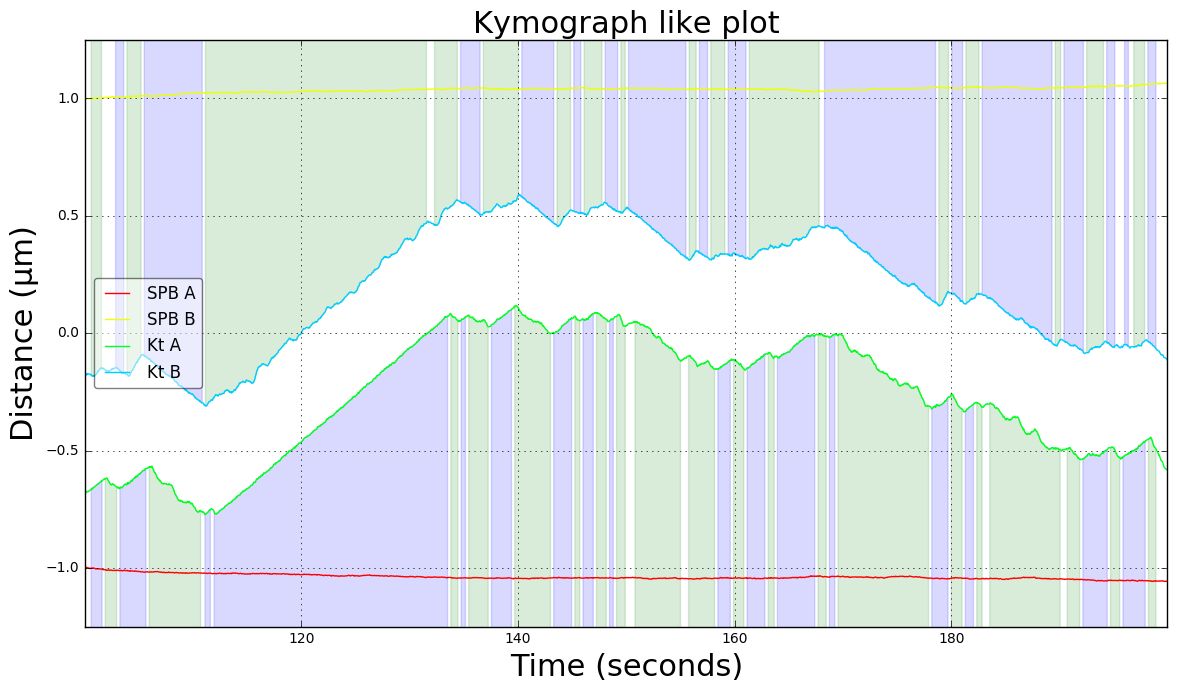

In [161]:
# Changement de dossier
os.chdir ("/home/sophie/Documents/ResultatsCytosim/oscillations/proba_asymetrique/"\
          "res/metaphase1kt_100MTseuil_20cohesinStiffness_140KTMTstiffness/run11/")
#Ouverture des fichiers
solid  = open("solid.txt")
data_solid = pd.read_table(solid, sep='\t', header=0, index_col=False, lineterminator='\n')
solid.close()

kt1x = data_solid["x.2"]
kt1y = data_solid["y.2"]
kt2x = data_solid["x.3"]
kt2y = data_solid["y.3"]


t0=int(100)
t1=int(200)

data_solid2 = data_solid[data_solid["time"]>t0]
data_solid2 = data_solid2[data_solid2["time"]<t1]
coherence = get_coherence(data_solid)
#print(coherence)
fig = kymo_directions (data_solid2)
fig